### Setup

In [1]:
import os 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import schedules
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Data processing

In [3]:
DATA_DIR = 'input_data\\raw'
PROCESSED_DATA_DIR = 'input_data\\processed'

In [4]:
def collect_paths_labels(input_dir: str) -> tuple[pd.Series, pd.Series]:
    files_paths = dict() 
    labels = []
    
    for folder in filter(lambda d: os.path.isdir(os.path.join(input_dir, d)), os.listdir(input_dir)):
        folder_path = os.path.join(input_dir, folder)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            full_file_name = os.path.join(folder, file)
            files_paths[full_file_name] = file_path
            labels.append(folder)
            
    return files_paths, labels

def create_input_df(files_paths: dict[str,str], labels: list[str]) -> pd.DataFrame:
    file_paths_series = pd.Series(list(files_paths.values()), name='file_path')
    labels_series = pd.Series(labels, name='label')
    return pd.concat([file_paths_series, labels_series], axis=1)

raw_paths, raw_labels = collect_paths_labels(DATA_DIR)
df_raw = create_input_df(raw_paths, raw_labels)

In [5]:
df_raw.sample(10, random_state=42)

,file_path,label
1089,input_data\raw\Sunrise\sunrise67.jpg,Sunrise
1103,input_data\raw\Sunrise\sunrise8.jpg,Sunrise
739,input_data\raw\Shine\shine73.jpg,Shine
140,input_data\raw\Cloudy\cloudy225.jpg,Cloudy
1018,input_data\raw\Sunrise\sunrise324.jpg,Sunrise
527,input_data\raw\Shine\shine11.jpg,Shine
812,input_data\raw\Sunrise\sunrise139.jpg,Sunrise
481,input_data\raw\Rain\rain69.jpg,Rain
1118,input_data\raw\Sunrise\sunrise93.jpg,Sunrise
950,input_data\raw\Sunrise\sunrise263.jpg,Sunrise


In [6]:
df_raw.loc[:, 'label'].value_counts()

label
Sunrise    357
Cloudy     300
Shine      253
Rain       215
Name: count, dtype: int64

In [7]:
RESIZED_IMAGE_SIZE = (128, 128)

for file, file_path in raw_paths.items():
    image = Image.open(file_path)
    resized_image = image.resize(RESIZED_IMAGE_SIZE)
    target_path = os.path.join(PROCESSED_DATA_DIR, file)
    os.makedirs(os.path.dirname(target_path), exist_ok=True)
    print(f'Saving {target_path}')
    try:
        resized_image.save(target_path)
    except OSError:
        print(f'Changing to RGB {target_path}')
        converted_image = resized_image.convert('RGB')
        converted_image.save(target_path)

print('Resized all images to image size:', RESIZED_IMAGE_SIZE)

Saving input_data\processed\Cloudy\cloudy1.jpg
Saving input_data\processed\Cloudy\cloudy10.jpg
Saving input_data\processed\Cloudy\cloudy100.jpg
Saving input_data\processed\Cloudy\cloudy101.jpg
Saving input_data\processed\Cloudy\cloudy102.jpg
Saving input_data\processed\Cloudy\cloudy103.jpg
Saving input_data\processed\Cloudy\cloudy104.jpg
Saving input_data\processed\Cloudy\cloudy105.jpg
Saving input_data\processed\Cloudy\cloudy106.jpg
Saving input_data\processed\Cloudy\cloudy107.jpg
Saving input_data\processed\Cloudy\cloudy108.jpg
Saving input_data\processed\Cloudy\cloudy109.jpg
Saving input_data\processed\Cloudy\cloudy11.jpg
Saving input_data\processed\Cloudy\cloudy110.jpg
Saving input_data\processed\Cloudy\cloudy111.jpg
Saving input_data\processed\Cloudy\cloudy112.jpg
Saving input_data\processed\Cloudy\cloudy113.jpg
Saving input_data\processed\Cloudy\cloudy114.jpg
Saving input_data\processed\Cloudy\cloudy115.jpg
Saving input_data\processed\Cloudy\cloudy116.jpg
Saving input_data\proces

In [8]:
processed_paths, processed_labels = collect_paths_labels(PROCESSED_DATA_DIR)
df_scaled = create_input_df(processed_paths, processed_labels)
df_scaled

,file_path,label
0,input_data\processed\Cloudy\cloudy1.jpg,Cloudy
1,input_data\processed\Cloudy\cloudy10.jpg,Cloudy
2,input_data\processed\Cloudy\cloudy100.jpg,Cloudy
3,input_data\processed\Cloudy\cloudy101.jpg,Cloudy
4,input_data\processed\Cloudy\cloudy102.jpg,Cloudy
...,...,...
1120,input_data\processed\Sunrise\sunrise95.jpg,Sunrise
1121,input_data\processed\Sunrise\sunrise96.jpg,Sunrise
1122,input_data\processed\Sunrise\sunrise97.jpg,Sunrise
1123,input_data\processed\Sunrise\sunrise98.jpg,Sunrise


### EDA

In [9]:
df_scaled.loc[:, 'label'].value_counts()

label
Sunrise    357
Cloudy     300
Shine      253
Rain       215
Name: count, dtype: int64

In [10]:
def plot_histogram(image: Image, ax, color, channel):
    """Plot histogram for a single channel."""
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 255))
    ax.plot(bin_edges[0:-1], histogram, color=color)
    ax.set_title(f"{channel} channel")
    ax.set_xlabel('Pixel Intensity (0-255)', fontsize=12)
    ax.set_ylabel('Frequency of Pixels', fontsize=12)

def compute_and_plot_histograms(image: Image):
    """Load image, compute histograms for each RGB channel, and plot them."""
    image_array = np.array(image)

     
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Red channel
    plot_histogram(image_array[:, :, 0], axs[0], 'red', 'Red')

    # Green channel
    plot_histogram(image_array[:, :, 1], axs[1], 'green', 'Green')

    # Blue channel
    plot_histogram(image_array[:, :, 2], axs[2], 'blue', 'Blue')
    
    plt.show()
    

def calculate_channel_correlation(image: Image):
    """Load image, split channels, and calculate correlation between RGB channels."""
    image_array = np.array(image)

    red_channel = image_array[:, :, 0].flatten()
    green_channel = image_array[:, :, 1].flatten()
    blue_channel = image_array[:, :, 2].flatten()

    channels_matrix = np.vstack((red_channel, green_channel, blue_channel))
    correlation_matrix = np.corrcoef(channels_matrix)

    return correlation_matrix
    

Displaying Sunrise weather.


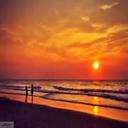

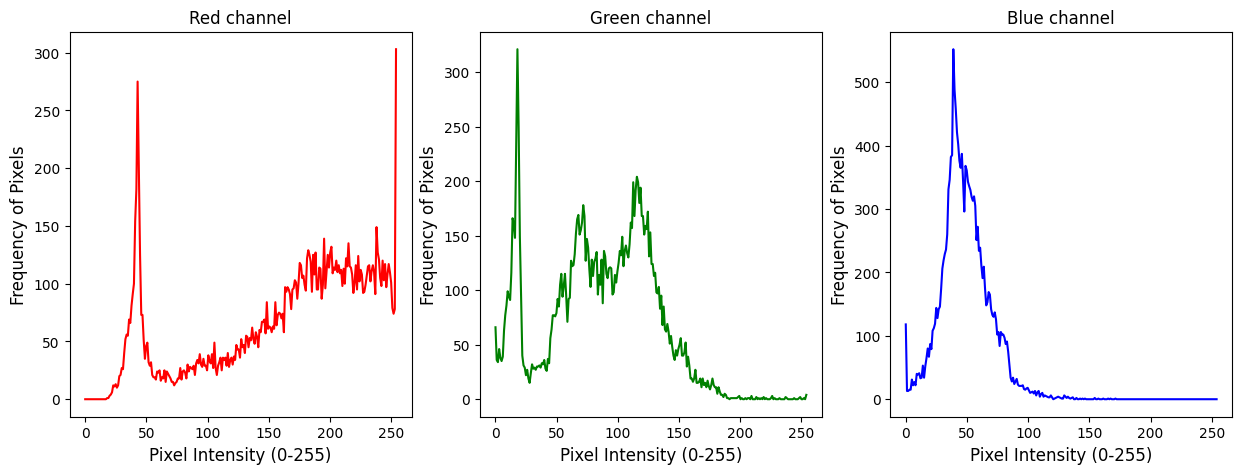

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.87439753 0.11723518]
 [0.87439753 1.         0.35094855]
 [0.11723518 0.35094855 1.        ]]
Displaying Cloudy weather.


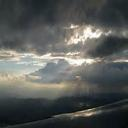

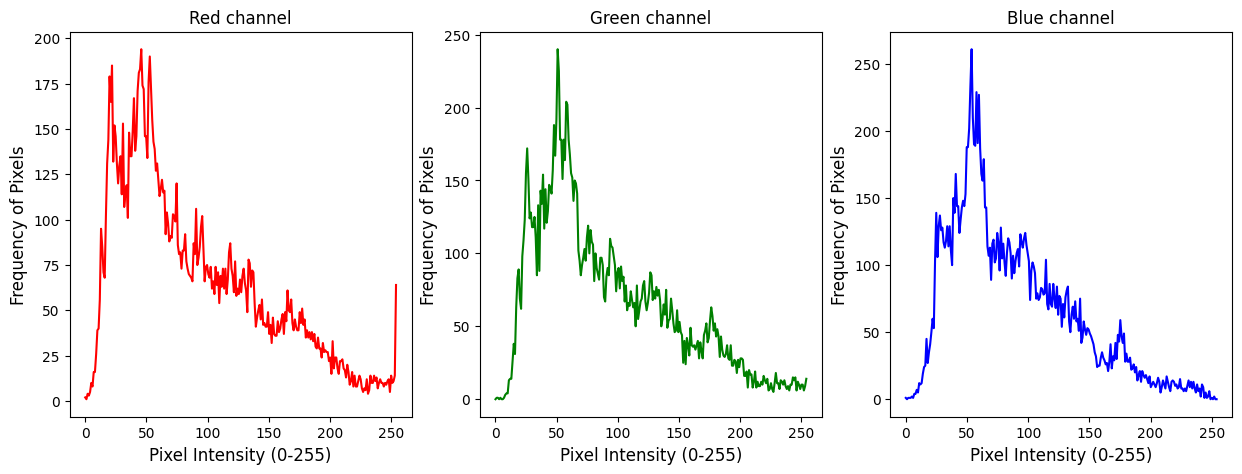

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.99655315 0.98574761]
 [0.99655315 1.         0.99427611]
 [0.98574761 0.99427611 1.        ]]
Displaying Shine weather.


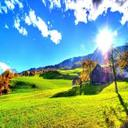

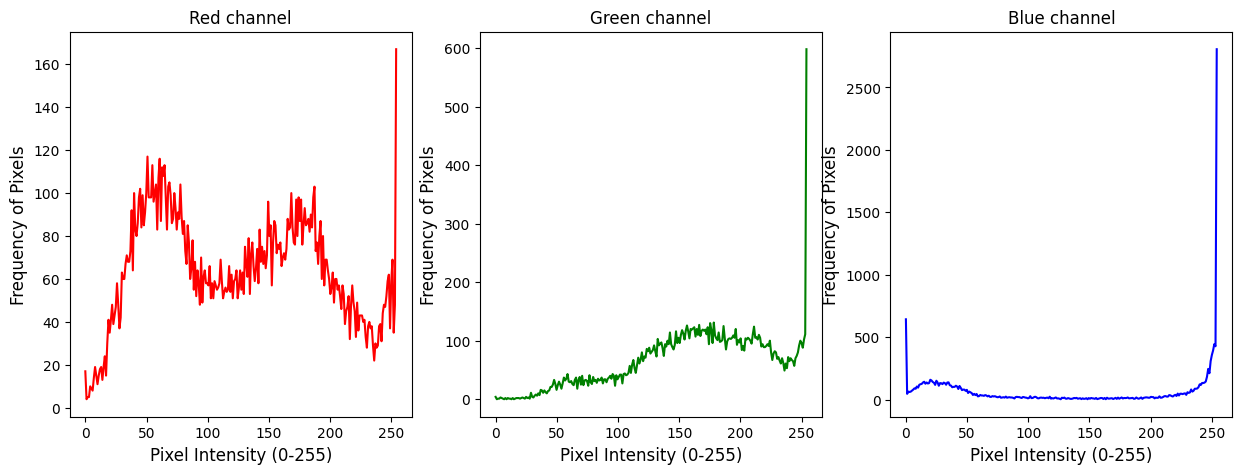

Correlation matrix between channels (Red, Green, Blue):
[[ 1.          0.71490927 -0.22536238]
 [ 0.71490927  1.          0.29695648]
 [-0.22536238  0.29695648  1.        ]]
Displaying Rain weather.


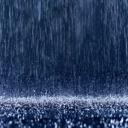

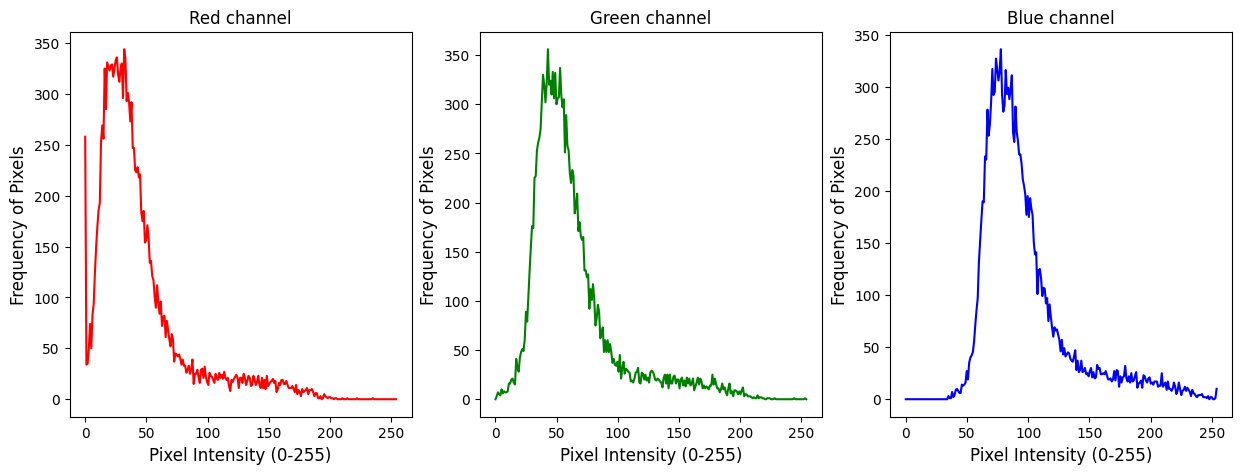

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.99704261 0.99279526]
 [0.99704261 1.         0.99447989]
 [0.99279526 0.99447989 1.        ]]


In [11]:
for unique_label in set(df_scaled.label):
    image_path = df_scaled.loc[df_scaled.label == unique_label, 'file_path'].sample(1, random_state=24).values[0]
    processed_image = Image.open(image_path)
    print(f'Displaying {unique_label} weather.')
    display(processed_image)
    compute_and_plot_histograms(processed_image)
    correlation_matrix = calculate_channel_correlation(processed_image)
    print("Correlation matrix between channels (Red, Green, Blue):")
    print(correlation_matrix)


### Data augmentation:
In the raw data such deformations are already present (and so would be used for augmentation):
* Artistict brightness, contrast changes, etc
* Rotations

Next affine transformations would also be applied:
* Zoom
* Shift
* Flips

In [12]:
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1),
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_df, test_df = train_test_split(df_scaled, test_size=0.4, random_state=SEED, stratify=df_scaled['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df['label'])

train_batches = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

validation_batches = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_batches = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

Found 540 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 450 validated image filenames belonging to 4 classes.


### Building the base model:
The first iteration is relatively shallow CNN with no particular tuning and regularizations applied

In [13]:
(WIDTH, HEIGHT), DIM = RESIZED_IMAGE_SIZE, 3
NUM_CLASSES = 4
NUM_FEATURES = 128
EPOCHS = 100

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [14]:
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_FEATURES),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

d:\conda\envs\comp_int\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    with_p = "p_numerator" in history.history.keys()
    metrics_count = 3 if with_p else 2
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, metrics_count, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.subplot(1, metrics_count, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

d:\conda\envs\comp_int\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.3682 - loss: 1.2980 - precision: 0.5311 - recall: 0.0448 - val_accuracy: 0.5259 - val_loss: 0.9223 - val_precision: 0.8413 - val_recall: 0.3926
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.6549 - loss: 0.8343 - precision: 0.8662 - recall: 0.4019 - val_accuracy: 0.6519 - val_loss: 0.9207 - val_precision: 0.7041 - val_recall: 0.5111
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.6649 - loss: 0.7516 - precision: 0.8371 - recall: 0.5199 - val_accuracy: 0.6148 - val_loss: 0.8649 - val_precision: 0.6729 - val_recall: 0.5333
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.6739 - loss: 0.7309 - precision: 0.7578 - recall: 0.4804 - val_accuracy: 0.6889 - val_loss: 0.8510 - val_precision: 0.7262 - val_recall: 0.4519
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.7289 - loss: 0.6780 - precision: 0.8710 - recall: 0.4992 - val_accuracy: 0.7111 - val_los

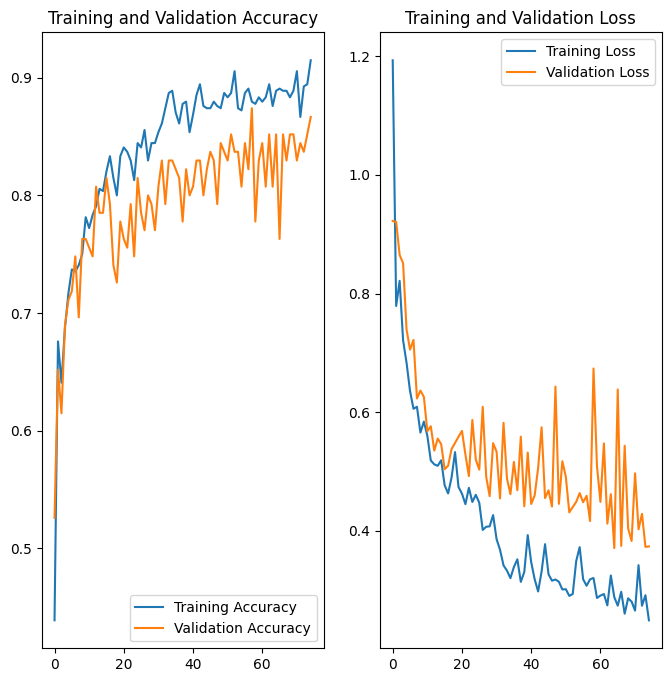

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8847 - loss: 0.3405 - precision: 0.8908 - recall: 0.8729
Test set results: [0.3352324664592743, 0.8822222352027893, 0.8901602029800415, 0.8644444346427917]


In [16]:
simple_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = simple_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = simple_cnn.evaluate(test_batches)
print("Test set results:", results)

That's a pretty good result, considering how noisy data is. However, there is an issue - model stopped training as it was unable to find better classification rule meaning that it underfits the data. 

To fix underfit either better data or more complex model is needed. As we already processed our dataset we can introduce higher complexity by removing the aggregation step (`GlobalAveragePooling`), now the model will process whole output of our convolutional feature extractors.

As the state space grows bigger for this model, early stopping constraint would be softened.

In [17]:
better_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(NUM_FEATURES),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.3523 - loss: 5.6252 - precision: 0.7449 - recall: 0.6497 - val_accuracy: 0.7111 - val_loss: 0.7759 - val_precision: 0.9423 - val_recall: 0.3630
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.7149 - loss: 0.6694 - precision: 0.8484 - recall: 0.5325 - val_accuracy: 0.6667 - val_loss: 0.9655 - val_precision: 0.6772 - val_recall: 0.6370
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.7677 - loss: 0.6532 - precision: 0.8237 - recall: 0.7223 - val_accuracy: 0.6222 - val_loss: 1.3003 - val_precision: 0.6357 - val_recall: 0.6074
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.7255 - loss: 0.7278 - precision: 0.7882 - recall: 0.6539 - val_accuracy: 0.8000 - val_loss: 0.5692 - val_precision: 0.8558 - val_recall: 0.6593
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.8027 - loss: 0.5733 - precision: 0.8324 - recall: 0.7397 - val_accuracy: 0.8074 - val_los

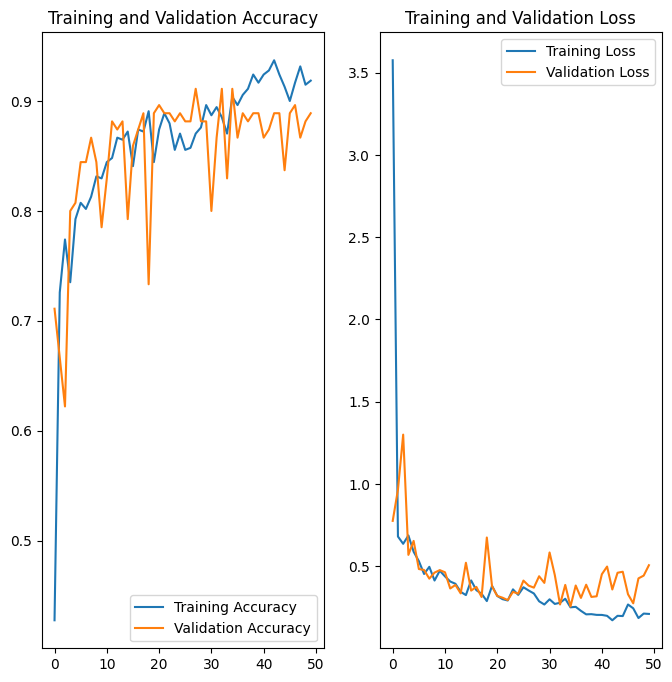

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9036 - loss: 0.2714 - precision: 0.9117 - recall: 0.8916
Test set results: [0.28391239047050476, 0.902222216129303, 0.9115646481513977, 0.8933333158493042]


In [18]:
better_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
]

history = better_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = better_cnn.evaluate(test_batches)
print("Test set results:", results)

This model is better, but now we face the overfit (validation trend does not match train trend), we find a good policy, but it does not generalize.

There are different solutions to this problem:
* Dropout - simply drop some of the values to further augment the inputs, but in a purely stochastic fashion
* Add class weights or regularize - our classes are not balanced, thus the distribution is flawed, which can be fixed by either explicitly stating some cases as more important or use regularization to find the best weight distribution. Here L2 Regulariztion would be used (as L1 regularization better works for implicit feature selection) 

In [19]:
best_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(NUM_FEATURES, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.3565 - loss: 5.0873 - precision: 0.7936 - recall: 0.6845 - val_accuracy: 0.6593 - val_loss: 1.9977 - val_precision: 0.7573 - val_recall: 0.5778
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.7333 - loss: 1.8023 - precision: 0.7753 - recall: 0.6049 - val_accuracy: 0.7926 - val_loss: 1.3110 - val_precision: 0.8047 - val_recall: 0.7630
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.7990 - loss: 1.1637 - precision: 0.8463 - recall: 0.7664 - val_accuracy: 0.8148 - val_loss: 0.9508 - val_precision: 0.8293 - val_recall: 0.7556
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.7631 - loss: 0.9059 - precision: 0.8068 - recall: 0.7275 - val_accuracy: 0.8000 - val_loss: 0.8057 - val_precision: 0.8475 - val_recall: 0.7407
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.8048 - loss: 0.7068 - precision: 0.8453 - recall: 0.7515 - val_accuracy: 0.7852 - val_los

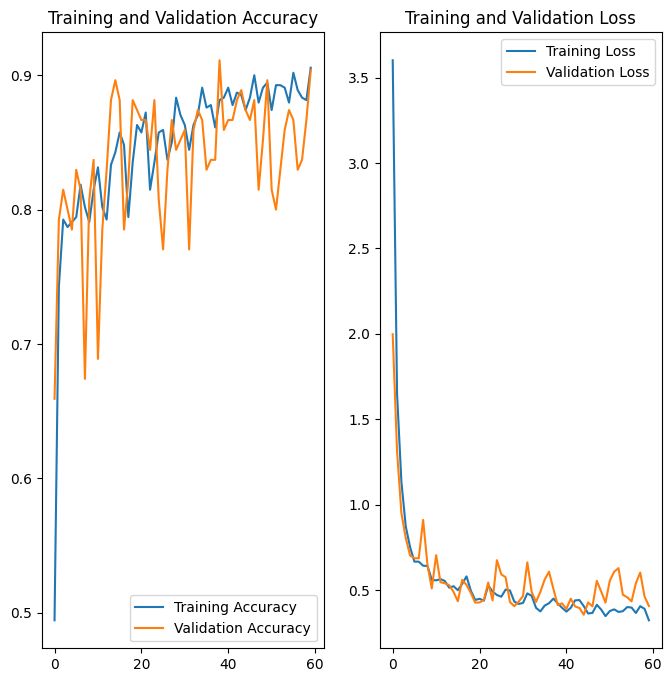

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9142 - loss: 0.3912 - precision: 0.9240 - recall: 0.8892
Test set results: [0.39496269822120667, 0.897777795791626, 0.9143518805503845, 0.8777777552604675]


In [20]:
best_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
]

history = best_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = best_cnn.evaluate(test_batches)
print("Test set results:", results)

Here overfit still happens, but it is postponed allowing us to reach better performance.